In [8]:
import math
import time
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier


# ============================================================
# 1. SCALING
# ============================================================
def compute_minmax(X):
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    return mins, maxs


def apply_minmax(X, mins, maxs):
    return (X - mins) / (maxs - mins + 1e-9)


# ============================================================
# 2. DISTANCES & KNN (FROM SCRATCH)
# ============================================================
def euclidean(a, b):
    return math.sqrt(np.sum((a - b) ** 2))


def manhattan(a, b):
    return np.sum(np.abs(a - b))


def knn_predict_single(X_train, y_train, x, k, metric="euclidean"):
    if metric == "euclidean":
        dist_fn = euclidean
    elif metric == "manhattan":
        dist_fn = manhattan
    else:
        raise ValueError(f"Unknown metric: {metric}")

    dists = []
    for xi, yi in zip(X_train, y_train):
        d = dist_fn(x, xi)
        dists.append((d, yi))

    # En yakın k komşu
    dists.sort(key=lambda t: t[0])
    k_neighbors = [lab for _, lab in dists[:k]]

    # Çoğunluk oylama
    counts = Counter(k_neighbors)
    pred_label = counts.most_common(1)[0][0]
    return pred_label


def knn_predict(X_train, y_train, X_test, k, metric="euclidean"):
    preds = []
    for x in X_test:
        preds.append(knn_predict_single(X_train, y_train, x, k, metric))
    return np.array(preds, dtype=int)


# ============================================================
# 3. METRİKLER
# ============================================================
def confusion_binary(y_true, y_pred):
    tp = fp = fn = tn = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 1:
            tp += 1
        elif yt == 0 and yp == 0:
            tn += 1
        elif yt == 0 and yp == 1:
            fp += 1
        elif yt == 1 and yp == 0:
            fn += 1
    return tp, fp, fn, tn


def evaluate_and_print(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tp, fp, fn, tn = confusion_binary(y_true, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"TP={tp}, FP={fp}, FN={fn}, TN={tn}")


# ============================================================
# 4. K-FOLD CV (HER METRIC İÇİN AYRI EN İYİ k SEÇİMİ)
# ============================================================
def k_fold_scores(X, y, k_values, metric="euclidean", folds=5, seed=42):
    """
    - X, y: unscaled numpy array
    - k_values: denenecek k listesi
    - metric: 'euclidean' veya 'manhattan'
    - folds: kaç fold
    Her k için ortalama accuracy döner.
    """
    n_samples = len(X)
    indices = np.arange(n_samples)

    rng = np.random.RandomState(seed)
    rng.shuffle(indices)

    folds_idx = np.array_split(indices, folds)

    scores = {k: [] for k in k_values}

    for i in range(folds):
        val_idx = folds_idx[i]
        train_idx = np.concatenate([folds_idx[j] for j in range(folds) if j != i])

        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]

        # Scaling sadece fold train'ine göre
        mins, maxs = compute_minmax(X_train_fold)
        X_train_scaled = apply_minmax(X_train_fold, mins, maxs)
        X_val_scaled = apply_minmax(X_val_fold, mins, maxs)

        for k in k_values:
            preds = knn_predict(X_train_scaled, y_train_fold, X_val_scaled, k, metric=metric)
            acc = np.mean(preds == y_val_fold)
            scores[k].append(acc)

    avg_scores = {k: float(np.mean(v)) for k, v in scores.items()}
    return avg_scores

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

# -----------------------------
# METRİK HESAPLAMA
# -----------------------------
def compute_metrics(y_true, y_pred, y_proba=None):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
    }
    if y_proba is not None:
        if y_proba.ndim > 1:
            pos_proba = y_proba[:, 1]
        else:
            pos_proba = y_proba
        metrics["ROC-AUC"] = roc_auc_score(y_true, pos_proba)
    else:
        metrics["ROC-AUC"] = None
    return metrics


def print_metrics_table(metrics, title="Results"):
    print(f"\n{title}:")
    print("-" * 40)
    for k, v in metrics.items():
        if v is None:
            print(f"{k:12s}: None")
        else:
            print(f"{k:12s}: {v:.4f}")


# -----------------------------
# CONFUSION MATRIX HEATMAP
# -----------------------------
def plot_confusion_matrix_heatmap(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    classes = ["0", "1"]
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.show()


# -----------------------------
# ROC CURVE
# -----------------------------
def plot_roc_curve_model(y_true, y_proba, title="ROC Curve"):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else:
        pos_proba = y_proba

    fpr, tpr, _ = roc_curve(y_true, pos_proba)
    auc = roc_auc_score(y_true, pos_proba)

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    ax.plot([0, 1], [0, 1], "k--", label="Random")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -----------------------------
# PRECISION–RECALL CURVE
# -----------------------------
def plot_precision_recall_curve_model(y_true, y_proba, title="Precision-Recall Curve"):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else:
        pos_proba = y_proba

    precision, recall, _ = precision_recall_curve(y_true, pos_proba)

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -----------------------------
# METRİK BAR CHART
# -----------------------------
def plot_metrics_bar(metrics, title="Model Performance"):
    names = [k for k in metrics.keys() if metrics[k] is not None]
    values = [metrics[k] for k in names]

    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(names, values)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.3)

    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h + 0.01,
            f"{h:.3f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()
def compute_metrics_with_proba_knn(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
    }

# ============================================================
# 5. TEK DATASET İÇİN TÜM PIPELINE (FROM-SCRATCH KNN)
# ============================================================
def run_knn_pipeline(X_train_df, X_test_df, y_train_ser, y_test_ser, dataset_name, random_seed=42):
    """
    X_train_df, X_test_df : pandas DataFrame (features)
    y_train_ser, y_test_ser: pandas Series (0/1 target)
    dataset_name           : string, sadece print için
    """
    print(f"\n{'='*60}")
    print(f"DATASET: {dataset_name}")
    print(f"Train size: {len(X_train_df)}")
    print(f"Test size : {len(X_test_df)}")
    print("="*60)

    # DataFrame -> numpy
    X_train_raw = X_train_df.to_numpy(dtype=float)
    X_test_raw = X_test_df.to_numpy(dtype=float)
    y_train = y_train_ser.to_numpy(dtype=int)
    y_test = y_test_ser.to_numpy(dtype=int)

    # k listesi
    k_list = [1, 5, 9, 13, 17, 21]

    # --- CV: Euclidean ---
    print("CV başlıyor (Euclidean)...")
    scores_euclidean = k_fold_scores(
        X_train_raw, y_train, k_list,
        metric="euclidean", folds=5, seed=random_seed
    )
    best_k_euclidean = max(scores_euclidean, key=scores_euclidean.get)
    print("Euclidean CV Scores:", scores_euclidean)
    print("Best k (Euclidean):", best_k_euclidean)
    print("-" * 50)

    # --- CV: Manhattan ---
    print("CV başlıyor (Manhattan)...")
    scores_manhattan = k_fold_scores(
        X_train_raw, y_train, k_list,
        metric="manhattan", folds=5, seed=random_seed
    )
    best_k_manhattan = max(scores_manhattan, key=scores_manhattan.get)
    print("Manhattan CV Scores:", scores_manhattan)
    print("Best k (Manhattan):", best_k_manhattan)
    print("-" * 50)

    # --- Final scaling train'e göre ---
    mins, maxs = compute_minmax(X_train_raw)
    X_train = apply_minmax(X_train_raw, mins, maxs)
    X_test = apply_minmax(X_test_raw, mins, maxs)

    # ======================================================================
    # FROM-SCRATCH KNN — EUCLIDEAN
    # ======================================================================
    start = time.time()
    y_pred_fs_euclidean = knn_predict(
        X_train, y_train, X_test,
        best_k_euclidean, metric="euclidean"
    )
    elapsed_fs_euclidean = time.time() - start
    metrics_fs_euclidean = compute_metrics_with_proba_knn(
        y_test, y_pred_fs_euclidean
    )
    evaluate_and_print(
        y_test, y_pred_fs_euclidean,
        f"[{dataset_name}] FROM-SCRATCH KNN (Euclidean, k={best_k_euclidean})"
    )
    print(f"Predict time (From-scratch Euclidean): {elapsed_fs_euclidean:.4f} seconds")

    # ---- GRAPHICS ----
    plot_confusion_matrix_heatmap(y_test, y_pred_fs_euclidean,
        title=f"{dataset_name} - FS KNN Euclidean Confusion Matrix")
    plot_metrics_bar(metrics_fs_euclidean,
        title=f"{dataset_name} - FS KNN Euclidean Metrics")

    # ======================================================================
    # FROM-SCRATCH KNN — MANHATTAN
    # ======================================================================
    start = time.time()
    y_pred_fs_manhattan = knn_predict(
        X_train, y_train, X_test,
        best_k_manhattan, metric="manhattan"
    )
    elapsed_fs_manhattan = time.time() - start
    metrics_fs_manhattan = compute_metrics_with_proba_knn(
        y_test, y_pred_fs_manhattan
    )
    evaluate_and_print(
        y_test, y_pred_fs_manhattan,
        f"[{dataset_name}] FROM-SCRATCH KNN (Manhattan, k={best_k_manhattan})"
    )
    print(f"Predict time (From-scratch Manhattan): {elapsed_fs_manhattan:.4f} seconds")

    # ---- GRAPHICS ----
    plot_confusion_matrix_heatmap(y_test, y_pred_fs_manhattan,
        title=f"{dataset_name} - FS KNN Manhattan Confusion Matrix")
    plot_metrics_bar(metrics_fs_manhattan,
        title=f"{dataset_name} - FS KNN Manhattan Metrics")

    # ======================================================================
    # SKLEARN KNN — EUCLIDEAN
    # ======================================================================
    sk_knn_euclidean = KNeighborsClassifier(
        n_neighbors=best_k_euclidean,
        metric="euclidean"
    )
    sk_knn_euclidean.fit(X_train, y_train)
    y_pred_sk_euclidean = sk_knn_euclidean.predict(X_test)

    metrics_sk_euclidean = compute_metrics_with_proba_knn(
        y_test, y_pred_sk_euclidean
    )
    evaluate_and_print(
        y_test, y_pred_sk_euclidean,
        f"[{dataset_name}] SKLEARN KNN (Euclidean, k={best_k_euclidean})"
    )

    # ---- GRAPHICS ----
    plot_confusion_matrix_heatmap(y_test, y_pred_sk_euclidean,
        title=f"{dataset_name} - Sklearn KNN Euclidean Confusion Matrix")
    plot_metrics_bar(metrics_sk_euclidean,
        title=f"{dataset_name} - SK KNN Euclidean Metrics")

    # ======================================================================
    # SKLEARN KNN — MANHATTAN
    # ======================================================================
    sk_knn_manhattan = KNeighborsClassifier(
        n_neighbors=best_k_manhattan,
        metric="manhattan"
    )
    sk_knn_manhattan.fit(X_train, y_train)
    y_pred_sk_manhattan = sk_knn_manhattan.predict(X_test)

    metrics_sk_manhattan = compute_metrics_with_proba_knn(
        y_test, y_pred_sk_manhattan
    )
    evaluate_and_print(
        y_test, y_pred_sk_manhattan,
        f"[{dataset_name}] SKLEARN KNN (Manhattan, k={best_k_manhattan})"
    )

    # ---- GRAPHICS ----
    plot_confusion_matrix_heatmap(y_test, y_pred_sk_manhattan,
        title=f"{dataset_name} - Sklearn KNN Manhattan Confusion Matrix")
    plot_metrics_bar(metrics_sk_manhattan,
        title=f"{dataset_name} - SK KNN Manhattan Metrics")

    print(f"\n[{dataset_name}] from-scratch KNN vs sklearn KNN karşılaştırması tamam.")

    return {
        "fs_euclidean": metrics_fs_euclidean,
        "fs_manhattan": metrics_fs_manhattan,
        "sk_euclidean": metrics_sk_euclidean,
        "sk_manhattan": metrics_sk_manhattan,
    }



DATASET: UCI Heart Disease
Train size: 736
Test size : 184
CV başlıyor (Euclidean)...
Euclidean CV Scores: {1: 0.7961389961389962, 5: 0.8043298400441257, 9: 0.8178985107556537, 13: 0.827394741680456, 17: 0.8110865968008826, 21: 0.8110774039345466}
Best k (Euclidean): 13
--------------------------------------------------
CV başlıyor (Manhattan)...
Manhattan CV Scores: {1: 0.8111141753998897, 5: 0.8342158485015627, 9: 0.834206655635227, 13: 0.8396120610406325, 17: 0.8423423423423422, 21: 0.8273763559477846}
Best k (Manhattan): 17
--------------------------------------------------

=== [UCI Heart Disease] FROM-SCRATCH KNN (Euclidean, k=13) ===
Accuracy : 0.8370
Precision: 0.8529
Recall   : 0.8529
F1-Score : 0.8529
TP=87, FP=15, FN=15, TN=67
Predict time (From-scratch Euclidean): 0.7228 seconds


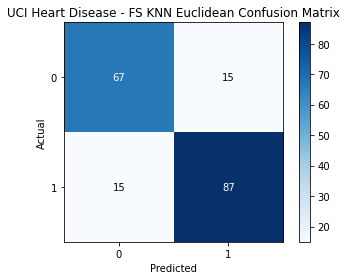

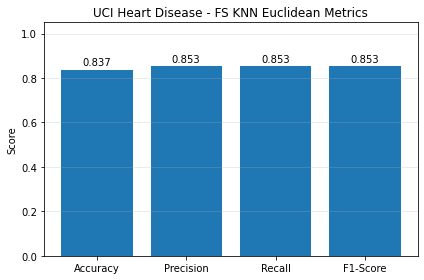


=== [UCI Heart Disease] FROM-SCRATCH KNN (Manhattan, k=17) ===
Accuracy : 0.8370
Precision: 0.8600
Recall   : 0.8431
F1-Score : 0.8515
TP=86, FP=14, FN=16, TN=68
Predict time (From-scratch Manhattan): 0.6753 seconds


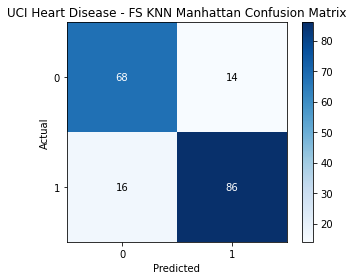

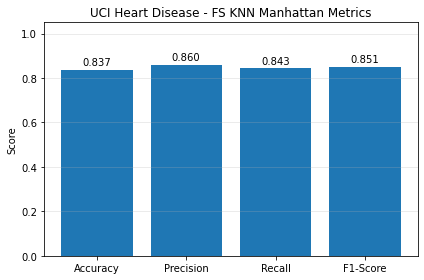


=== [UCI Heart Disease] SKLEARN KNN (Euclidean, k=13) ===
Accuracy : 0.8370
Precision: 0.8529
Recall   : 0.8529
F1-Score : 0.8529
TP=87, FP=15, FN=15, TN=67


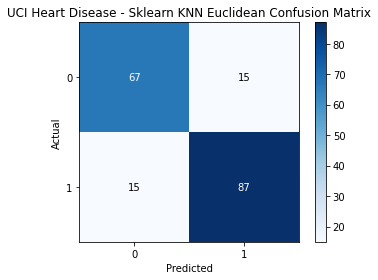

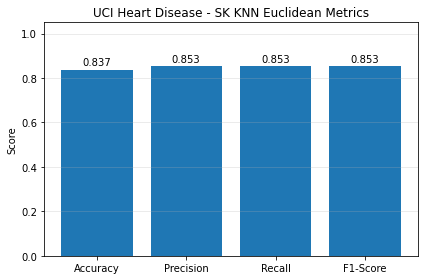


=== [UCI Heart Disease] SKLEARN KNN (Manhattan, k=17) ===
Accuracy : 0.8370
Precision: 0.8600
Recall   : 0.8431
F1-Score : 0.8515
TP=86, FP=14, FN=16, TN=68


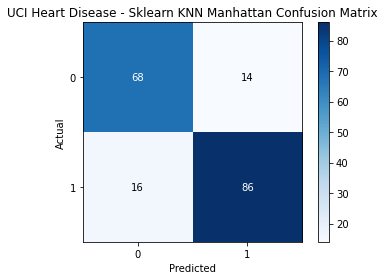

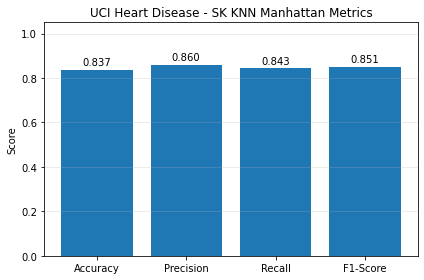


[UCI Heart Disease] from-scratch KNN vs sklearn KNN karşılaştırması tamam.

DATASET: Processed Heart (Kaggle)
Train size: 734
Test size : 184
CV başlıyor (Euclidean)...
Euclidean CV Scores: {1: 0.8133724722765819, 5: 0.8378715869909608, 9: 0.8446836268754077, 13: 0.8542260739912404, 17: 0.8515236231478893, 21: 0.855595937004939}
Best k (Euclidean): 21
--------------------------------------------------
CV başlıyor (Manhattan)...
Manhattan CV Scores: {1: 0.8119932904668717, 5: 0.8419345820519988, 9: 0.8487466219364457, 13: 0.8515049855558662, 17: 0.8569658000186375, 21: 0.8583263442363247}
Best k (Manhattan): 21
--------------------------------------------------

=== [Processed Heart (Kaggle)] FROM-SCRATCH KNN (Euclidean, k=21) ===
Accuracy : 0.8533
Precision: 0.8571
Recall   : 0.8824
F1-Score : 0.8696
TP=90, FP=15, FN=12, TN=67
Predict time (From-scratch Euclidean): 0.7223 seconds


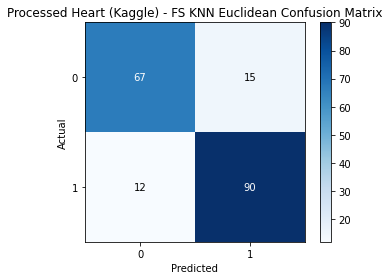

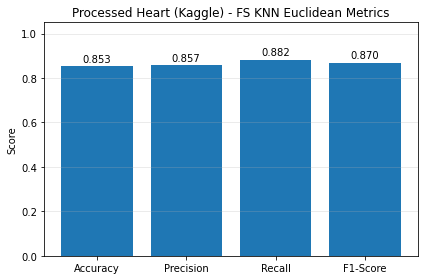


=== [Processed Heart (Kaggle)] FROM-SCRATCH KNN (Manhattan, k=21) ===
Accuracy : 0.8641
Precision: 0.8667
Recall   : 0.8922
F1-Score : 0.8792
TP=91, FP=14, FN=11, TN=68
Predict time (From-scratch Manhattan): 0.7158 seconds


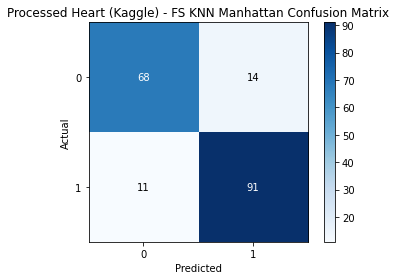

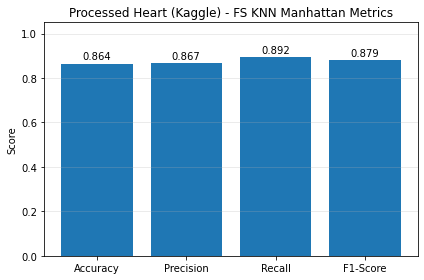


=== [Processed Heart (Kaggle)] SKLEARN KNN (Euclidean, k=21) ===
Accuracy : 0.8533
Precision: 0.8571
Recall   : 0.8824
F1-Score : 0.8696
TP=90, FP=15, FN=12, TN=67


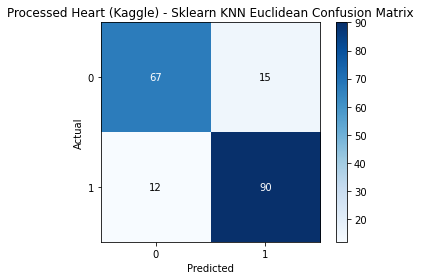

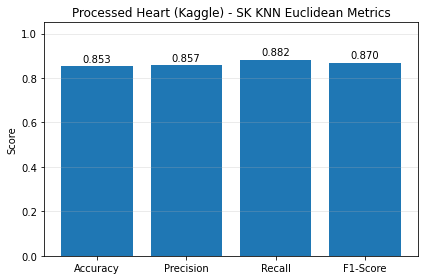


=== [Processed Heart (Kaggle)] SKLEARN KNN (Manhattan, k=21) ===
Accuracy : 0.8641
Precision: 0.8667
Recall   : 0.8922
F1-Score : 0.8792
TP=91, FP=14, FN=11, TN=68


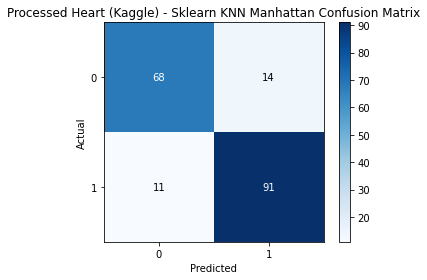

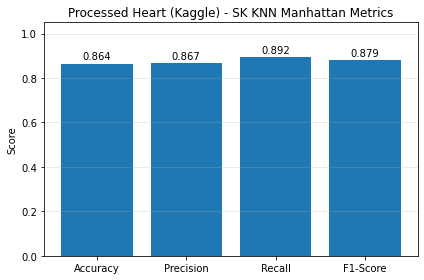


[Processed Heart (Kaggle)] from-scratch KNN vs sklearn KNN karşılaştırması tamam.


{'fs_euclidean': {'Accuracy': 0.8532608695652174,
  'Precision': 0.8571428571428571,
  'Recall': 0.8823529411764706,
  'F1-Score': 0.8695652173913043},
 'fs_manhattan': {'Accuracy': 0.8641304347826086,
  'Precision': 0.8666666666666667,
  'Recall': 0.8921568627450981,
  'F1-Score': 0.8792270531400966},
 'sk_euclidean': {'Accuracy': 0.8532608695652174,
  'Precision': 0.8571428571428571,
  'Recall': 0.8823529411764706,
  'F1-Score': 0.8695652173913043},
 'sk_manhattan': {'Accuracy': 0.8641304347826086,
  'Precision': 0.8666666666666667,
  'Recall': 0.8921568627450981,
  'F1-Score': 0.8792270531400966}}

In [9]:
# ============================================================
# 6. İKİ FARKLI DATASET İÇİN PIPELINE ÇALIŞTIR
# ============================================================

# 1) preprocessed_heart_disease_uci.csv
df1 = pd.read_csv("preprocessed_heart_disease_uci.csv")
X1 = df1.drop("target", axis=1)
y1 = df1["target"]

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=42, stratify=y1
)

run_knn_pipeline(X1_train, X1_test, y1_train, y1_test, dataset_name="UCI Heart Disease")


# 2) processed_heart.csv
df2 = pd.read_csv("processed_heart.csv")
X2 = df2.drop("HeartDisease", axis=1)
y2 = df2["HeartDisease"]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

run_knn_pipeline(X2_train, X2_test, y2_train, y2_test, dataset_name="Processed Heart (Kaggle)")
